# Homework 2. Clustering.

### Выполнили: Дорофеева Елена и Соколова Ирина, 22МАГ-ИАД.

In [372]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance_matrix
from sklearn import preprocessing

In [373]:
x = pd.read_excel('X_4_3.xlsx', names=['X1', 'X2', 'X3', 'X4'])
y = pd.read_excel('Y_4_3.xlsx', names=['Y1', 'Y2', 'Y3', 'Y4'])

In [374]:
x.head()

,X1,X2,X3,X4
0,5.925133,0.956640,8.980344,-3.055211
1,6.441260,1.170630,9.370629,-2.929369
2,6.301320,1.160937,9.119830,-2.818510
3,6.400442,1.240521,9.079320,-2.678879
4,6.311495,1.169958,9.113115,-2.801620


In [375]:
x.shape

(199, 4)

In [376]:
y.head()

,Y1,Y2,Y3,Y4
0,1.896167,1.104732,1.715516,0.802851
1,1.212324,-0.121333,-0.084197,1.043010
2,0.875004,0.906996,1.267052,0.861366
3,0.917798,0.995384,1.071257,1.111678
4,1.236041,-0.157617,0.142423,1.147995


In [377]:
y.shape

(199, 4)

#### Выполнить первичную обработку данных. Сделать первые выводы

In [378]:
x.describe()

,X1,X2,X3,X4
count,199.000000,199.000000,199.000000,199.000000
mean,4.024644,1.008293,5.024407,-0.999763
std,2.669096,1.200462,2.669064,1.709639
min,-0.841539,-1.075717,0.204338,-4.038928
25%,1.879909,0.059831,3.002572,-2.392984
50%,3.853551,0.974095,4.936659,-1.095333
75%,6.102236,1.942835,7.216971,0.296676
max,8.808940,3.090735,9.785204,2.121285


In [379]:
A = x.isnull()

In [380]:
print('Missing values by features:', A.sum(), sep='\n')

Missing values by features:
X1    0
X2    0
X3    0
X4    0
dtype: int64


##### Проверим данные на выбросы с помощью расстояния Махаланобиса

In [381]:
def MahalanobisDist(y, data, cov=None):
  
    y_mu = y - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(y_mu, inv_covmat)
    mahal = np.dot(left, y_mu.T)
    return mahal.diagonal()

In [382]:
def MD_detectOutliers(data, extreme=False, verbose=False):
    MD = MahalanobisDist(y=data, data=data)
  

    std = np.std(MD)
    k = 4. * std if extreme else 3. * std
    m = np.mean(MD)
    up_t = m + k
    low_t = m - k
    outliers = []
    for i in range(len(MD)):
        if (MD[i] >= up_t) or (MD[i] <= low_t):
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [383]:
outliers_x = np.array(x)

outliers_indices_x = MD_detectOutliers(x, verbose=True)


print("Outliers Indices: {}\n".format(outliers_indices_x))
print("Outliers:")
for ii in outliers_indices_x:
    print(outliers_x[ii])

Outliers Indices: [43]

Outliers:
[8.29483613 3.00480046 7.57527087 0.71956525]


У данных Х_4 был один выброс, удалим его

In [384]:
x.drop(labels = outliers_indices_x,axis = 0)
print('Outliers in X_4 were deleted')

Outliers in X_4 were deleted


##### Посмотрим на матрицу корреляций признаков

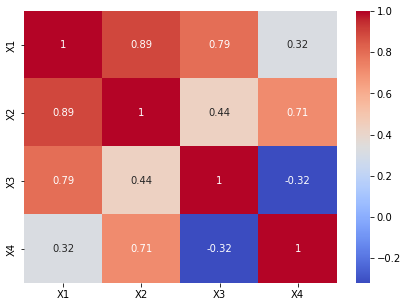

In [385]:
plt.figure(figsize=(7, 5))
sns.heatmap(x.corr(), cmap="coolwarm", annot=True)

По корреляционной матрице видно, что признаки Х1 и Х2 имеют сильную зависимость, поэтому можно выделить главные компоненты при помощи метода PCA.

In [386]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [387]:
#посмотрим на 3 компоненты
pca_x = PCA(n_components=3)
pca_x.fit(x)
res_pca_x = np.array(pca_x.transform(x))

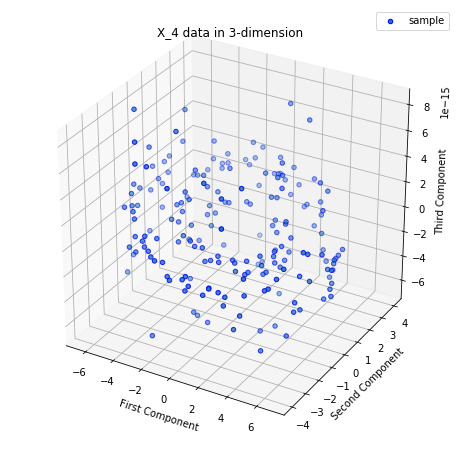

In [388]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.scatter(res_pca_x[:, 0], res_pca_x[:, 1], res_pca_x[:, 2], label='sample', edgecolors='blue')
plt.legend()
ax.set_ylabel('Second Component')
ax.set_xlabel('First Component')
ax.set_zlabel('Third Component')
plt.title('X_4 data in 3-dimension')
plt.show()

In [389]:
#посмотрим на 2 компоненты
pca_x = PCA(n_components=2)
pca_x.fit(x)
res_pca_x = np.array(pca_x.transform(x))

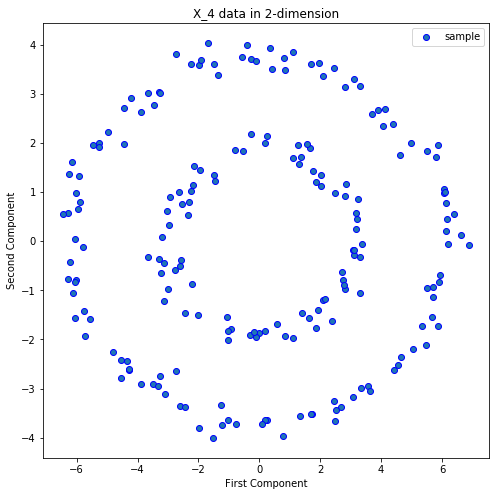

In [390]:
plt.figure(figsize=(8, 8))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], label='sample', edgecolors='blue')
plt.legend()
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.title('X_4 data in 2-dimension')
plt.show()

Скорее всего, в данных X_4 должно быть 2 кластера

<Figure size 800x640 with 0 Axes>

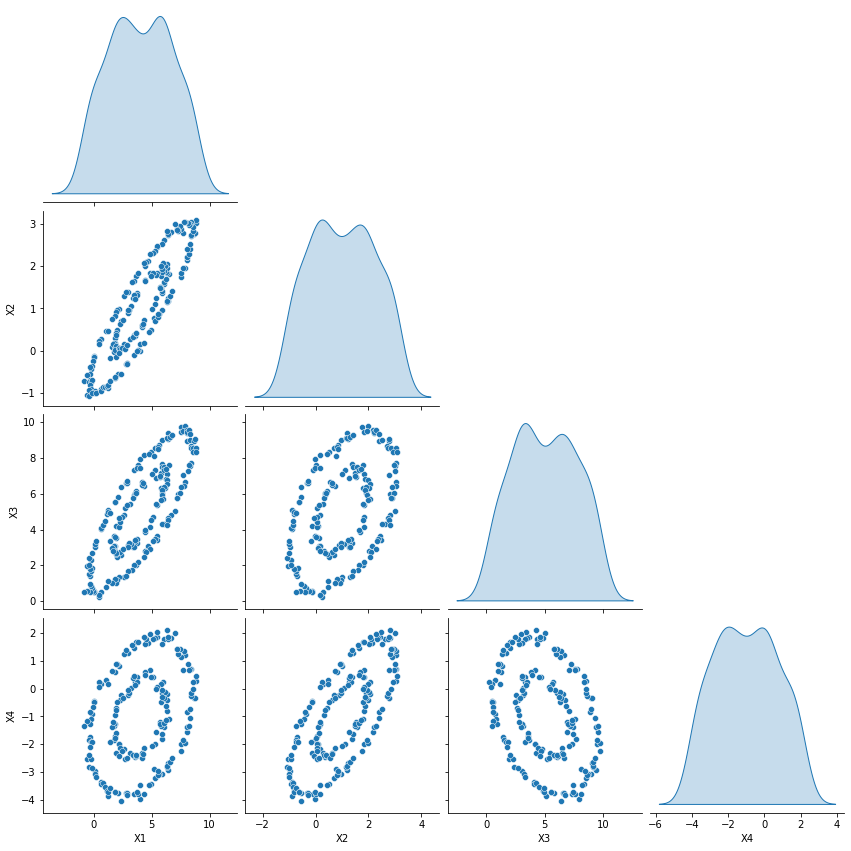

In [391]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(x, diag_kind="kde", corner=True, height=3)
plt.show()

#### Исследуем данные Y_4

In [392]:
y.describe()

,Y1,Y2,Y3,Y4
count,199.000000,199.000000,199.000000,199.000000
mean,1.283770,0.590942,0.883167,1.000633
std,0.471478,0.519317,0.838728,0.172658
min,0.636356,-0.548875,-0.337439,0.442493
25%,0.929545,0.066778,0.061588,0.898431
50%,1.070734,0.874215,0.956539,0.984995
75%,1.887661,1.007324,1.767225,1.088969
max,2.203434,1.286696,2.350317,1.493608


In [393]:
A = y.isnull()

In [394]:
A.head()

,Y1,Y2,Y3,Y4
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


In [395]:
print('Missing values by features:', A.sum(), sep='\n')

Missing values by features:
Y1    0
Y2    0
Y3    0
Y4    0
dtype: int64


Пропусков нет, проверим выбросы

In [396]:
outliers_y = np.array(y)

outliers_indices_y = MD_detectOutliers(y, verbose=True)


print("Outliers Indices: {}\n".format(outliers_indices_y))
print("Outliers:")
for ii in outliers_indices_y:
    print(outliers_y[ii])

Outliers Indices: [ 57  80 105 141]

Outliers:
[2.11410009 1.18348281 1.54347221 0.98223281]
[1.98617422 0.84124479 2.35031734 1.29642694]
[0.93027326 1.10752628 0.96375663 0.44249301]
[0.73399413 1.10615736 1.12064077 1.49360783]


В данных было 4 выброса, тоже удалим их

In [397]:
y.drop(labels = outliers_indices_y,axis = 0)
print('Outliers in Y_4 were deleted')

Outliers in Y_4 were deleted


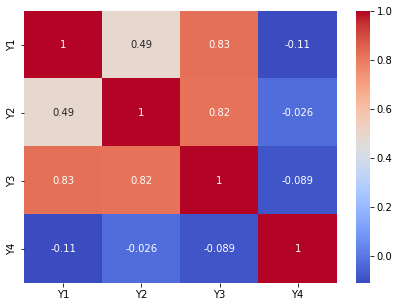

In [398]:
plt.figure(figsize=(7, 5))
sns.heatmap(y.corr(), cmap="coolwarm", annot=True)

По матрице корреляций видим, что признаки Y_1 и Y_3 зависимы, так же попробуем выделить главные компоненты.

In [399]:
#посмотрим на 3 компоненты
pca_y = PCA(n_components=3)
pca_y.fit(y)
res_pca_y = np.array(pca_y.transform(y))

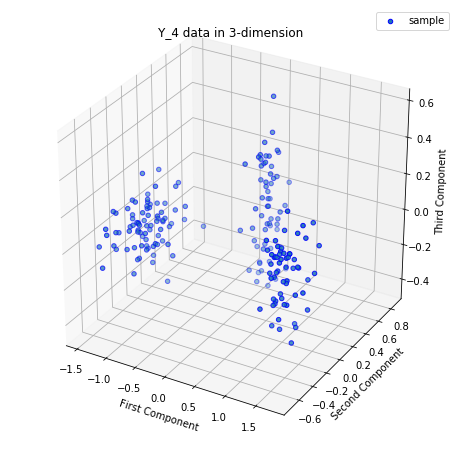

In [400]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ax.scatter(res_pca_y[:, 0], res_pca_y[:, 1], res_pca_y[:, 2], label='sample', edgecolors='blue')
plt.legend()
ax.set_ylabel('Second Component')
ax.set_xlabel('First Component')
ax.set_zlabel('Third Component')
plt.title('Y_4 data in 3-dimension')
plt.show()

In [401]:
#посмотрим на 2 компоненты
pca_y = PCA(n_components=2)
pca_y.fit(y)
res_pca_y = np.array(pca_y.transform(y))

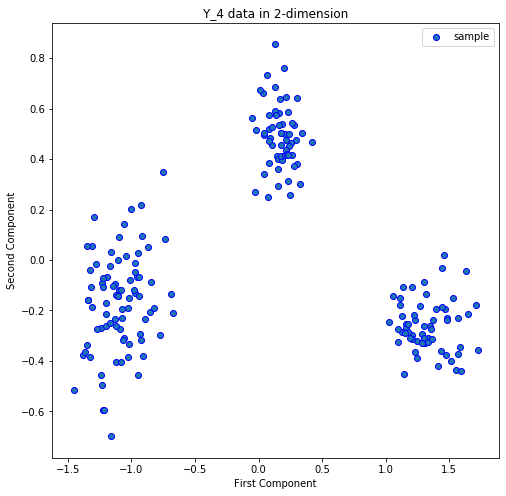

In [402]:
plt.figure(figsize=(8, 8))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], label='sample', edgecolors='blue')
plt.legend()
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.title('Y_4 data in 2-dimension')
plt.show()

<Figure size 800x640 with 0 Axes>

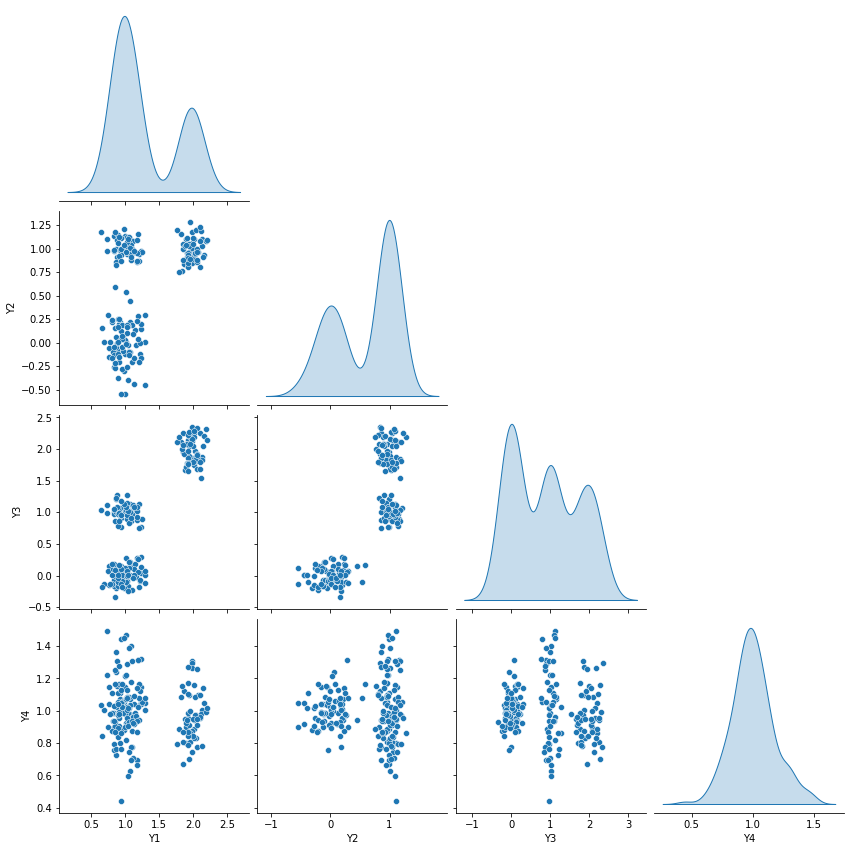

In [403]:
plt.figure(figsize=(10,8), dpi= 80)
sns.pairplot(y, diag_kind="kde", corner=True, height=3)
plt.show()

Вывод: По полученным графикам можно предположить, что данные X_4 стоит разбивать на 2 кластера, а данные Y_4 - на 3.

### Подготовка данных: выбрать расстояние и перейти к матрице близостей

В качестве расстояния возьмем самое популярное - евклидово. Посчитаем матрицу расстояний.

In [404]:
dist_X = distance_matrix(x, x)

In [405]:
np.around(dist_X[:5, :10], 2)

array([[0.  , 0.69, 0.51, 0.68, 0.53, 0.84, 2.05, 1.14, 1.85, 2.14],
       [0.69, 0.  , 0.31, 0.39, 0.32, 0.37, 2.5 , 0.59, 2.11, 2.4 ],
       [0.51, 0.31, 0.  , 0.19, 0.02, 0.33, 2.19, 0.64, 1.82, 2.1 ],
       [0.68, 0.39, 0.19, 0.  , 0.17, 0.19, 2.16, 0.49, 1.73, 2.01],
       [0.53, 0.32, 0.02, 0.17, 0.  , 0.31, 2.19, 0.62, 1.81, 2.09]])

In [406]:
dist_Y = distance_matrix(y, y)

In [407]:
np.around(dist_Y[:5, :10], 2)

array([[0.  , 2.3 , 1.13, 1.22, 2.15, 0.17, 0.62, 2.11, 0.29, 1.89],
       [2.3 , 0.  , 1.74, 1.64, 0.25, 2.3 , 2.66, 0.48, 2.43, 0.64],
       [1.13, 1.74, 0.  , 0.33, 1.62, 1.2 , 1.51, 1.38, 1.21, 1.22],
       [1.22, 1.64, 0.33, 0.  , 1.51, 1.3 , 1.63, 1.25, 1.36, 1.09],
       [2.15, 0.25, 1.62, 1.51, 0.  , 2.14, 2.48, 0.5 , 2.28, 0.66]])

Теперь перейдем к матрице близостей.

In [408]:
def sim(dist, b=0.75):
    return np.exp(- (dist ** 2) / (2 * (b ** 2)))

In [409]:
sim_X = sim(dist_X)

In [410]:
np.around(sim_X[:5, :10], 2)

array([[1.  , 0.65, 0.79, 0.67, 0.78, 0.53, 0.02, 0.31, 0.05, 0.02],
       [0.65, 1.  , 0.92, 0.87, 0.92, 0.88, 0.  , 0.73, 0.02, 0.01],
       [0.79, 0.92, 1.  , 0.97, 1.  , 0.91, 0.01, 0.7 , 0.05, 0.02],
       [0.67, 0.87, 0.97, 1.  , 0.97, 0.97, 0.02, 0.81, 0.07, 0.03],
       [0.78, 0.92, 1.  , 0.97, 1.  , 0.92, 0.01, 0.71, 0.06, 0.02]])

In [411]:
sim_Y = sim(dist_Y)

In [412]:
np.around(sim_Y[:5, :10], 2)

array([[1.  , 0.01, 0.32, 0.27, 0.02, 0.98, 0.71, 0.02, 0.93, 0.04],
       [0.01, 1.  , 0.07, 0.09, 0.94, 0.01, 0.  , 0.82, 0.01, 0.7 ],
       [0.32, 0.07, 1.  , 0.91, 0.1 , 0.28, 0.13, 0.18, 0.27, 0.26],
       [0.27, 0.09, 0.91, 1.  , 0.13, 0.22, 0.09, 0.25, 0.19, 0.35],
       [0.02, 0.94, 0.1 , 0.13, 1.  , 0.02, 0.  , 0.8 , 0.01, 0.68]])

Построим графовую модель данных

In [413]:
import networkx as nx

In [414]:
G_x = nx.from_numpy_matrix(sim_X)

In [415]:
G_y = nx.from_numpy_matrix(sim_Y)

### Кластеризация для числа кластеров к = 2

In [416]:
import networkx.algorithms.community as nx_comm

In [417]:
def modularity(G, clusters):
    first_num = min(clusters)
    last_num = max(clusters)
    
    labels = []
    
    for i in range(first_num, last_num + 1):
        labels.append(np.where(clusters == i)[0])
        
    return nx_comm.modularity(G, labels)

#### K-means

In [418]:
from sklearn.cluster import KMeans

In [419]:
kmeans_x = KMeans(n_clusters=2).fit_predict(x)

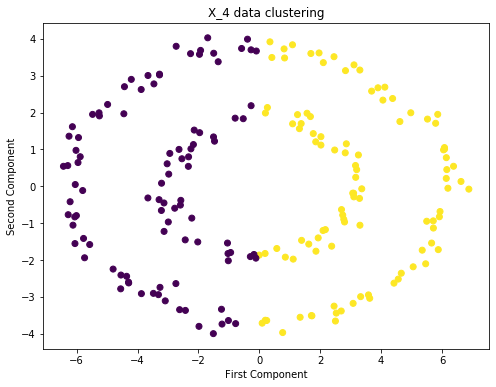

In [420]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=kmeans_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [421]:
kmeans_y = KMeans(n_clusters=2).fit_predict(y)

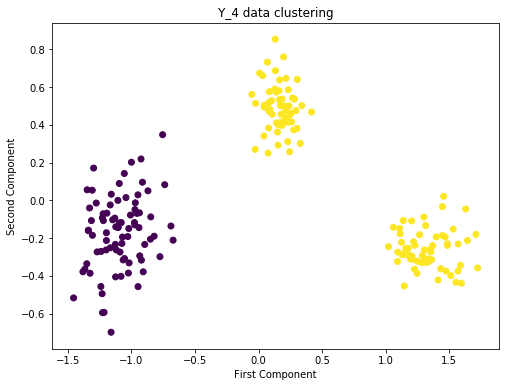

In [422]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=kmeans_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод
В результате работы алгоритма K-means на данных Y_4 можно сделать очевидный вывод, что такое разбиение не является оптимальным, так как можно улучшить разбиение одного из кластеров, поделя его на два

#### EM-algorithm

In [423]:
from sklearn.mixture import GaussianMixture

In [424]:
em_x = GaussianMixture(n_components=2, max_iter=300, covariance_type="full").fit_predict(x)

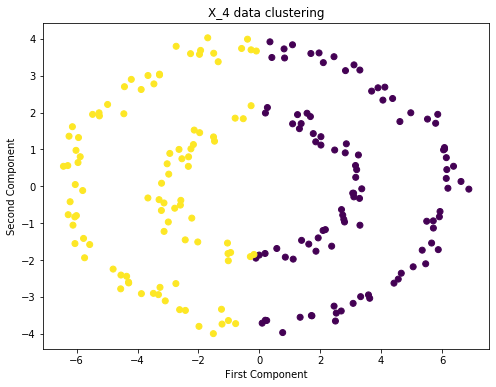

In [425]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=em_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [426]:
em_y = GaussianMixture(n_components=2, max_iter=300, covariance_type="full").fit_predict(y)

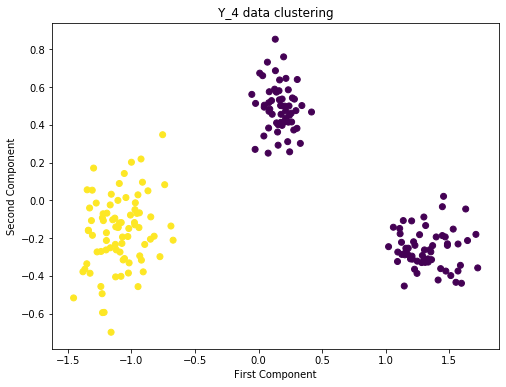

In [427]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=em_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод
Результаты работы EM-алгоритма при разбиении на 2 кластера обоих наборов данных похожи на результаты работы алгоритма K-means.

#### Single Linkage

In [428]:
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram

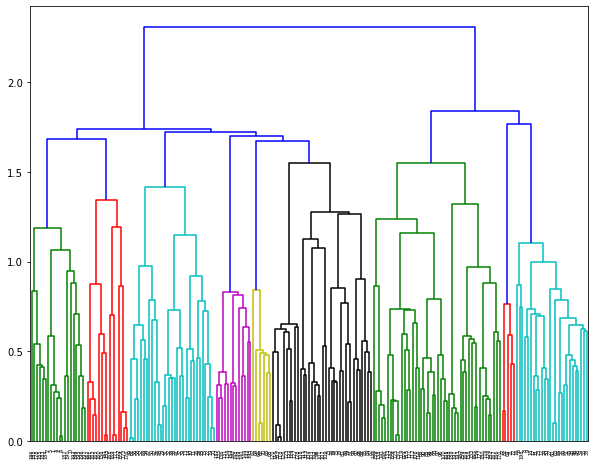

In [429]:
dendrogram_x = linkage(sim_X, 'single')
fig = plt.figure(figsize=(10, 8))
_ = dendrogram(dendrogram_x)
plt.show()

In [430]:
snglink_x = fcluster(dendrogram_x, 2, criterion='distance')

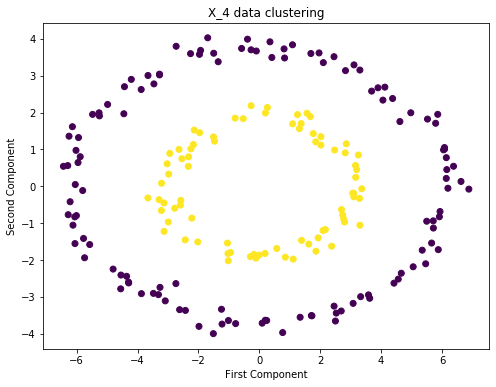

In [431]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=snglink_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

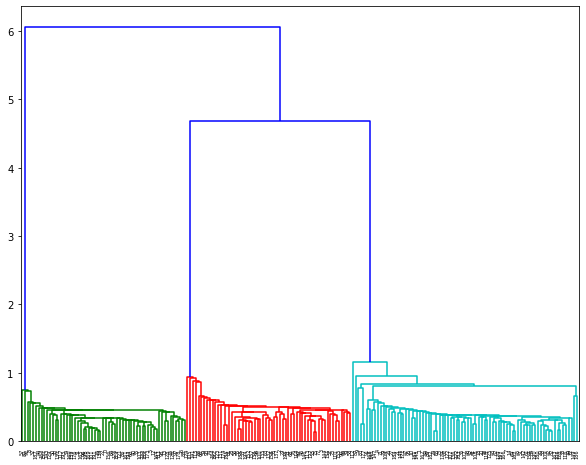

In [432]:
dendrogram_y = linkage(sim_Y, 'single')
fig = plt.figure(figsize=(10, 8))
_ = dendrogram(dendrogram_y)
plt.show()

In [433]:
snglink_y = fcluster(dendrogram_y, 6, criterion='distance')

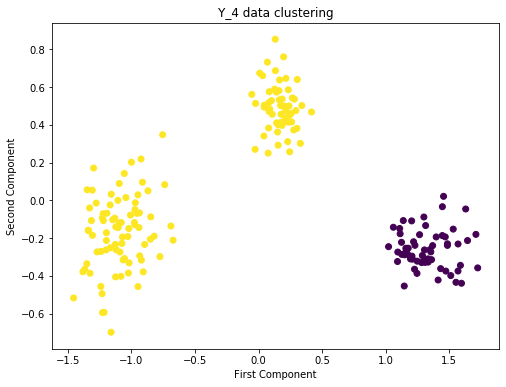

In [434]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=snglink_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод
Алгоритм Single Linkage лучше отработал на данных X_4, так как получившиеся разбиение отличается от тех, которое получилось у EM-алгоритма и K-means (вместо того, чтобы делить данные пополам на 2 кластера, этот алгоритм разделил на 2 окружности). Для данных Y_4 отличий от работы EM-алгоритма и K-means практически нет, что обусловлено тем, что в данных Y_4 очевидно оптимальное числов кластеров равно 3.

#### Spectral algorithm

In [435]:
from sklearn.cluster import SpectralClustering
sp_x = SpectralClustering(n_clusters=2, assign_labels='discretize', affinity='nearest_neighbors', random_state=16).fit_predict(x)

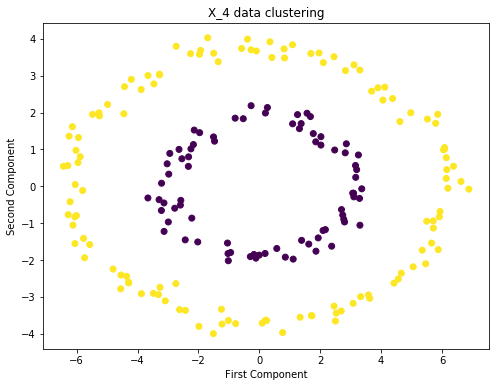

In [436]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=sp_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [437]:
sp_y = SpectralClustering(n_clusters=2, assign_labels='discretize', affinity='nearest_neighbors', random_state=16).fit_predict(y)

C:\Users\Елена\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


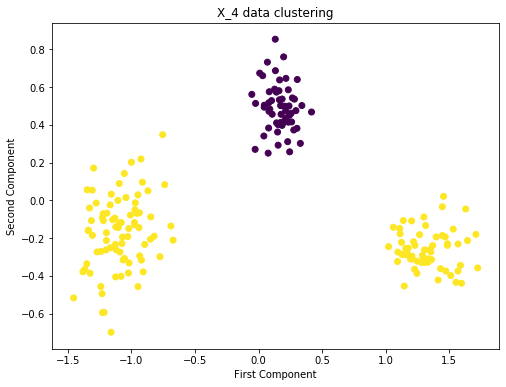

In [438]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=sp_y)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод
Работа алгоритма ничем не отличается от результатов ЕМ-алгоритма и K-means.

### Результаты

In [439]:
from scipy.special import comb
import itertools

In [440]:
def rand_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [441]:
results_x = {'K-means': kmeans_x, 'EM-algorithm': em_x, 'Single Linkage': snglink_x, 'Spectral algorithm': sp_x}
results_y = {'K-means': kmeans_y, 'EM-algorithm': em_y, 'Single Linkage': snglink_y, 'Spectral algorithm': sp_y}

In [442]:
print("Modularity for X_4")
for key, value in results_x.items():
    print(key, modularity(G_x, value))

Modularity for X_4
K-means 0.4644891667529168
EM-algorithm 0.4637712424932016
Single Linkage 0.4719355631566002
Spectral algorithm 0.47193556315659596


In [443]:
print("Modularity for Y_4")
for key, value in results_y.items():
    print(key, modularity(G_y, value))

Modularity for Y_4
K-means 0.3831182758902813
EM-algorithm 0.3831182758902857
Single Linkage 0.2917417273088193
Spectral algorithm 0.23229502322174142


In [444]:
print("RAND score for X_4")
combinations_x = itertools.combinations(results_x, 2)
for name_1, name_2 in list(combinations_x):  
    score = rand_score(results_x[name_1], results_x[name_2])
    print("RAND score between ", name_1, " and ", name_2, " is ", score)

RAND score for X_4
RAND score between  K-means  and  EM-algorithm  is  0.9899497487437185
RAND score between  K-means  and  Single Linkage  is  0.498096543322674
RAND score between  K-means  and  Spectral algorithm  is  0.498096543322674
RAND score between  EM-algorithm  and  Single Linkage  is  0.4985026140805035
RAND score between  EM-algorithm  and  Spectral algorithm  is  0.4985026140805035
RAND score between  Single Linkage  and  Spectral algorithm  is  1.0


In [445]:
print("RAND score for Y_4")
combinations_y = itertools.combinations(results_y, 2)
for name_1, name_2 in list(combinations_y):  
    score = rand_score(results_y[name_1], results_y[name_2])
    print("RAND score between ", name_1, " and ", name_2, " is ", score)

RAND score for Y_4
RAND score between  K-means  and  EM-algorithm  is  1.0
RAND score between  K-means  and  Single Linkage  is  0.5807319425409878
RAND score between  K-means  and  Spectral algorithm  is  0.5807319425409878
RAND score between  EM-algorithm  and  Single Linkage  is  0.5807319425409878
RAND score between  EM-algorithm  and  Spectral algorithm  is  0.5807319425409878
RAND score between  Single Linkage  and  Spectral algorithm  is  0.514846962083143


#### Вывод
Исходя из оценки модулярности для данных Х_4, результат работы алгоритм Single Linkage оказался слегка лучше, чем у других алгоритмов, и визуально разбиение на кластеры у него получилось более логичным. Аналогична оценка RAND, которая показывает, что все алгоритмы друг с другом схожи, кроме Single Linkage. Это подтверждает полученный результат, так как это единственный алгоритм, у которого получилось отличное от других разбиение на кластеры.

Оценка модулярности для данных Y_4 на всех алгоритмах оставляет желать лучшего, так как эти данные состоят из трех кластеров, в то же время результат работы алгоритм Single Linkage оказался слегка лучше. RAND score для K-means, Spectral algorithm, EM-algorithm равен 1, (кластеры совпали), Single Linkage отличается.

### Кластеризация для числа кластеров к = 3

#### K-means

In [446]:
kmeans_3_x = KMeans(n_clusters=3).fit_predict(x)

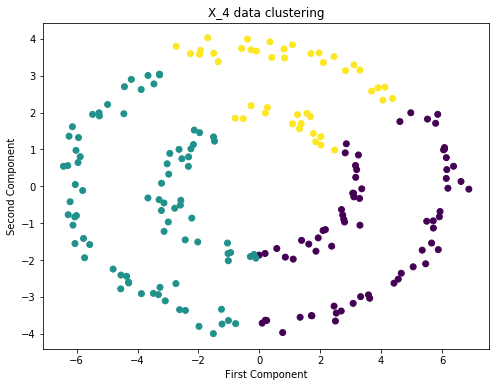

In [447]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=kmeans_3_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [448]:
kmeans_3_y = KMeans(n_clusters=3).fit_predict(y)

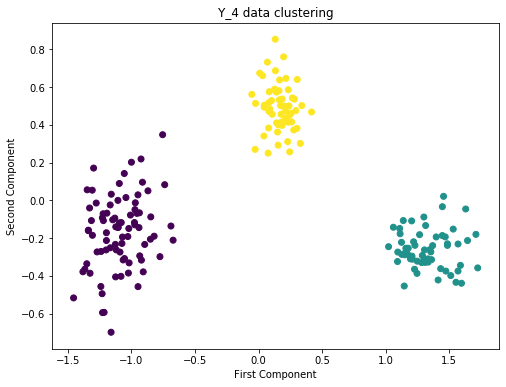

In [449]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=kmeans_3_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод

Заметно, что разбиение на классы в случае Х_4 не улучшилось, а в случае У_4 дает правильный результат.

#### EM-algorithm

In [450]:
em_3_x = GaussianMixture(n_components=3, max_iter=300, covariance_type="full").fit_predict(x)

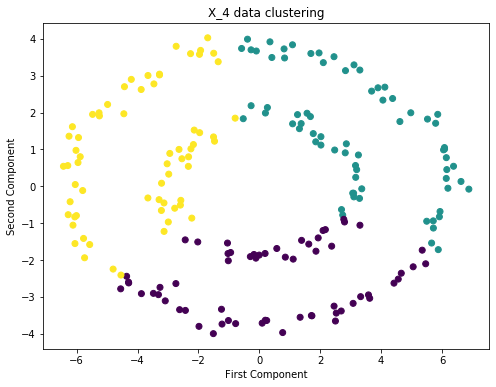

In [451]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=em_3_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [452]:
em_3_y = GaussianMixture(n_components=3, max_iter=300, covariance_type="full").fit_predict(y)

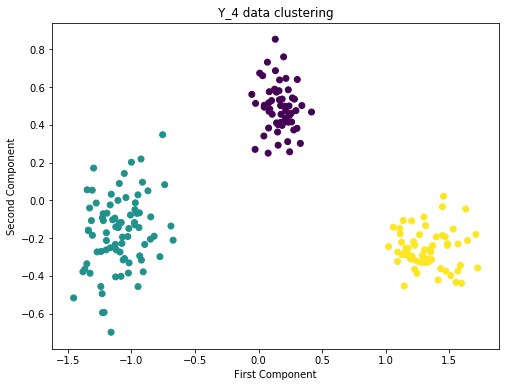

In [453]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=em_3_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод

Результат аналогичен Kmeans.

#### Single Linkage

In [454]:
snglink_3_x = fcluster(dendrogram_x, t=1.8, criterion='distance')

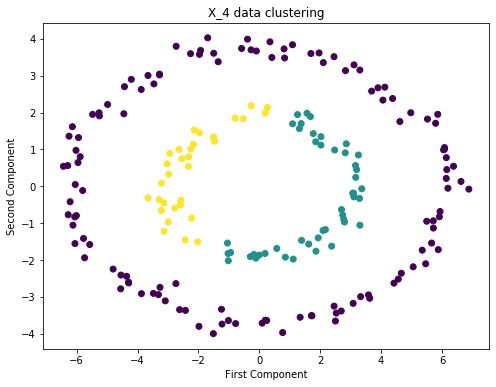

In [455]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=snglink_3_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [456]:
snglink_3_y = fcluster(dendrogram_y, t=1.8, criterion='distance')

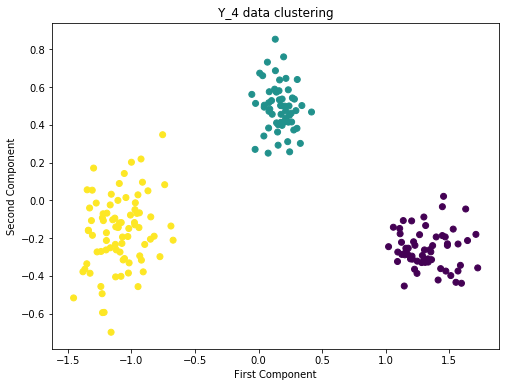

In [457]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=snglink_3_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод

Результат Single Linkage для Х_4 лучше, чем у Kmeans и EM-algorithm, для Y_4 результат аналогичен Kmeans и EM-algorithm.

#### Spectral algorithm

In [458]:
sp_3_x = SpectralClustering(n_clusters=3, assign_labels='discretize', affinity='nearest_neighbors', random_state=7).fit_predict(x)

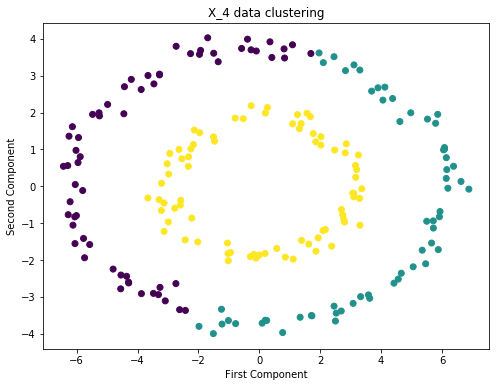

In [459]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_x[:, 0], res_pca_x[:, 1], c=sp_3_x)
plt.title("X_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

In [460]:
sp_3_y = SpectralClustering(n_clusters=3, assign_labels='discretize', affinity='nearest_neighbors', random_state=7).fit_predict(y)

C:\Users\Елена\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


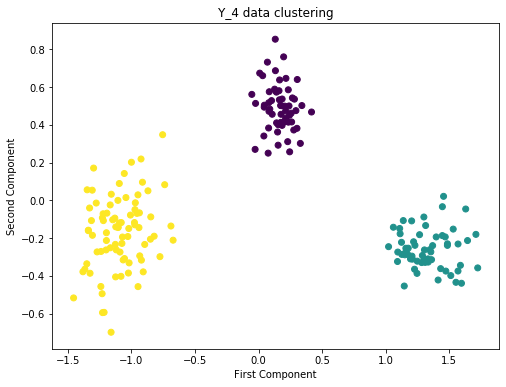

In [461]:
plt.figure(figsize=(8, 6))
plt.scatter(res_pca_y[:, 0], res_pca_y[:, 1], c=sp_3_y)
plt.title("Y_4 data clustering")
plt.ylabel('Second Component')
plt.xlabel('First Component')
plt.show()

##### Вывод

Для X_4 и Н_4 результат аналогичен Kmeans и EM-algorithm.

### Результаты

In [462]:
results_3_x = {'K-means': kmeans_3_x, 'EM-algorithm': em_3_x, 'Single Linkage': snglink_3_x, 'Spectral algorithm': sp_3_x}
results_3_y = {'K-means': kmeans_3_y, 'EM-algorithm': em_3_y, 'Single Linkage': snglink_3_y, 'Spectral algorithm': sp_3_y}

In [463]:
print("Modularity for X_4")
for key, value in results_3_x.items():
    print(key, modularity(G_x, value))

Modularity for X_4
K-means 0.5897776089472493
EM-algorithm 0.5945984590137398
Single Linkage 0.5569998632497029
Spectral algorithm 0.6151587214206765


In [464]:
print("Modularity for Y_4")
for key, value in results_3_y.items():
    print(key, modularity(G_y, value))

Modularity for Y_4
K-means 0.45357751321042283
EM-algorithm 0.4535775132104209
Single Linkage 0.4535775132104239
Spectral algorithm 0.45357751321042394


In [465]:
print("RAND score for X_4")
combinations_x = itertools.combinations(results_3_x, 2)
for name_1, name_2 in list(combinations_x):  
    score = rand_score(results_3_x[name_1], results_3_x[name_2])
    print("RAND score between ", name_1, " and ", name_2, " is ", score)

RAND score for X_4
RAND score between  K-means  and  EM-algorithm  is  0.7068676716917923
RAND score between  K-means  and  Single Linkage  is  0.5376884422110553
RAND score between  K-means  and  Spectral algorithm  is  0.631795340338054
RAND score between  EM-algorithm  and  Single Linkage  is  0.5470788284858636
RAND score between  EM-algorithm  and  Spectral algorithm  is  0.6113395259123903
RAND score between  Single Linkage  and  Spectral algorithm  is  0.7387949850261408


In [466]:
print("RAND score for Y_4")
combinations_y = itertools.combinations(results_3_y, 2)
for name_1, name_2 in list(combinations_y):  
    score = rand_score(results_3_y[name_1], results_3_y[name_2])
    print("RAND score between ", name_1, " and ", name_2, " is ", score)

RAND score for Y_4
RAND score between  K-means  and  EM-algorithm  is  1.0
RAND score between  K-means  and  Single Linkage  is  1.0
RAND score between  K-means  and  Spectral algorithm  is  1.0
RAND score between  EM-algorithm  and  Single Linkage  is  1.0
RAND score between  EM-algorithm  and  Spectral algorithm  is  1.0
RAND score between  Single Linkage  and  Spectral algorithm  is  1.0


#### Вывод


Исходя из оценки модулярности для данных Х_4, результат работы алгоритм Single Linkage уже не лучше у других алгоритмов, лучшая оценка модулярности принадлежит EM-algorithm. Оценка RAND, показывает, что все алгоритмы друг с другом схожи, немного больше отличаются друг от друга K-means  и  EM-algorithm.

Оценка модулярности для данных Y_4 на всех алгоритмах одинакова, так как они выделили одинаковые 3 кластера, поэтому и RAND score у всех алгоритмов 1.

### Общий случай

#### Предложите (или найдите готовый) способ определения возможного числа кластеров в данных

Для определения числа кластеров будем использовать метод силуэта. Коэффициент «силуэт» вычисляется с помощью среднего внутрикластерного расстояния (a) и среднего расстояния до ближайшего кластера (b) по каждому образцу так:
$$ \cfrac{(b - a)}{max(a, b)} $$

In [467]:
from sklearn.metrics import silhouette_score

In [468]:
slh_x = []

for i in range(2, 10):
    km = KMeans(n_clusters=i).fit(x)
    preds = km.predict(x)
    slh_x.append(silhouette_score(x, preds))

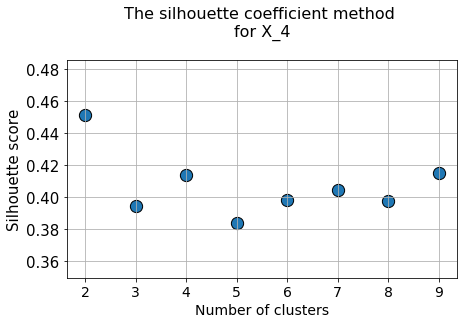

In [469]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor X_4\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=slh_x,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,10)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Из графика видно, что для данных Х_4 оптимальное число кластеров - 2. Проверим на методе локтя

In [470]:
elbow = []
for i in range(1, 10):
    km = KMeans(n_clusters=i).fit(x)
    elbow.append(km.inertia_)

C:\Users\Елена\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


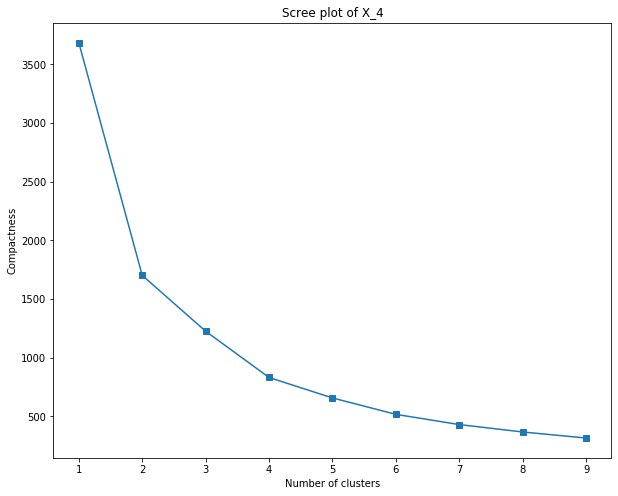

In [471]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 10), elbow, marker='s');
plt.xlabel('Number of clusters')
plt.ylabel('Compactness')
plt.title('Scree plot of X_4')
plt.show()

Минус методя локтя заключается в том, что по графику не всегда точно понятно, какое оптимальное число кластеров - 2, 3 или 4. Так как в методе силуэта мы получили оптимальное число 2, то его и будем придерживаться.

In [472]:
slh_y = []

for i in range(2, 10):
    km = KMeans(n_clusters=i).fit(y)
    preds = km.predict(y)
    slh_y.append(silhouette_score(y, preds))

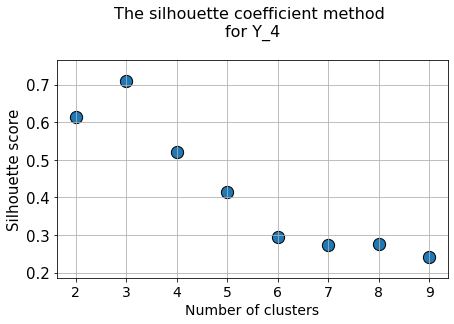

In [473]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor Y_4\n",fontsize=16)
plt.scatter(x=[i for i in range(2,10)],y=slh_y,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,10)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

Для Y_4 оптимальное число кластеров будет 3.

In [474]:
elbow = []
for i in range(1, 10):
    km = KMeans(n_clusters=i).fit(y)
    elbow.append(km.inertia_)

C:\Users\Елена\AppData\Roaming\Python\Python37\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


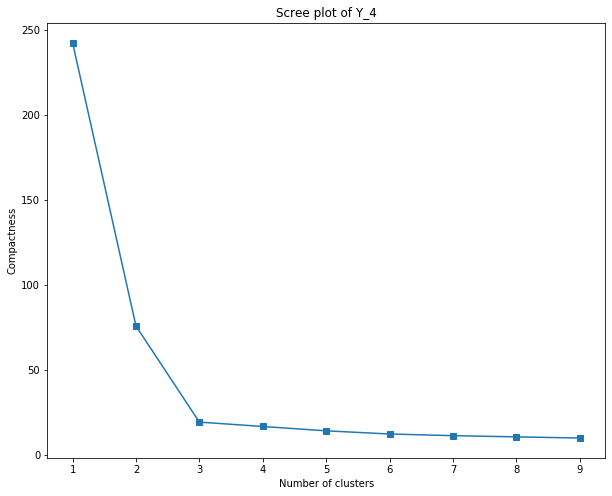

In [475]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, 10), elbow, marker='s');
plt.xlabel('Number of clusters')
plt.ylabel('Compactness')
plt.title('Scree plot of Y_4')
plt.show()

Для Y_4 в методе локтя также явно видно, что оптимальное число кластеров - 3.

Вывод: был получен такой же результат, как и из предыдущих пунктов - для Х_4 оптимальное число кластеров равно двум, а для Y_4 - 3.

#### Предложите какой-либо другой критерий оценки качества кластеризации (кроме модулярности)

Индекс Дэвида-Болдуина

Индекс Дэвиса-Болдуина представляет собой меру среднего сходства каждого сформированного кластера с кластером, наиболее близким к данному. Разделимость между кластерами характеризуется значением знаменателя - разницей между центрами кластеров, а компактность кластеров относительно друг друга характеризуется значением числителя - отклонением экземпляров данных от центра кластеров.

In [476]:
from sklearn.metrics import davies_bouldin_score

In [477]:
print("Результат разбиения на 2 кластера Х_4")
for key, value in results_x.items():
    print(key, davies_bouldin_score(x, value))

Результат разбиения на 2 кластера Х_4
K-means 0.8538803255667509
EM-algorithm 0.8539301556209792
Single Linkage 33.76800108473413
Spectral algorithm 33.76800108473413


In [478]:
print("Результат разбиения на 2 кластера Y_4")
for key, value in results_y.items():
    print(key, davies_bouldin_score(y, value))

Результат разбиения на 2 кластера Y_4
K-means 0.5575176029275379
EM-algorithm 0.5575176029275379
Single Linkage 0.5353046021927577
Spectral algorithm 2.0400813062567877


In [479]:
print("Результат разбиения на 3 кластера Х_4")
for key, value in results_3_x.items():
    print(key, davies_bouldin_score(x, value))

Результат разбиения на 3 кластера Х_4
K-means 0.862642772469805
EM-algorithm 0.9669257890944022
Single Linkage 3.442319277535088
Spectral algorithm 1.596895023104212


In [480]:
print("Результат разбиения на 3 кластера Y_4")
for key, value in results_3_y.items():
    print(key, davies_bouldin_score(y, value))

Результат разбиения на 3 кластера Y_4
K-means 0.41816289714188687
EM-algorithm 0.41816289714188687
Single Linkage 0.41816289714188687
Spectral algorithm 0.41816289714188687


Индекс Дэвида-Болдуина показал, что для данных Х_4 лучше всего работают Single Linkage и Spectral Algorithm на 2х кластерах, а для Y_4 - Spectral algorithm на 2х кластерах.

Индекс Калински-Харабаса (критерий отношения дисперсии)

Индекс Калински-Харабаса - это мера того, насколько объект похож на его собственный кластер (сплоченность) по сравнению с другими кластерами (разделение). Здесь сплоченность оценивается на основе расстояний от точек данных в кластере до его центроида кластера, а разделение основывается на расстоянии центроидов кластера от глобального центроида. Более высокое значение индекса Калински-Харабаса означает, что кластеры плотные и хорошо разделены.

In [481]:
from sklearn.metrics import calinski_harabasz_score

In [482]:
#будем сравнивать разбиение Х_4 на 2 класса

for key, value in results_x.items():
    print(key, calinski_harabasz_score(x, value))

K-means 229.54419874169497
EM-algorithm 229.4750606245298
Single Linkage 0.12709554455147942
Spectral algorithm 0.12709554455147942


In [483]:
#будем сравнивать разбиение Х_4 на 3 класса

for key, value in results_3_x.items():
    print(key, calinski_harabasz_score(x, value))

K-means 196.56497710875396
EM-algorithm 168.0142577890911
Single Linkage 8.663903924418255
Spectral algorithm 84.26141833039968


In [484]:
#будем сравнивать разбиение Y_4 на 2 класса

for key, value in results_y.items():
    print(key, calinski_harabasz_score(y, value))

K-means 432.7824064497534
EM-algorithm 432.7824064497534
Single Linkage 343.23440720483296
Spectral algorithm 20.32290237532584


In [485]:
#будем сравнивать разбиение Y_4 на 3 класса

for key, value in results_3_y.items():
    print(key, calinski_harabasz_score(y, value))

K-means 1130.781601424565
EM-algorithm 1130.781601424565
Single Linkage 1130.781601424565
Spectral algorithm 1130.781601424565


Индекс Калински-Харабаса показал, что на каждых данных для каждого числа кластеров лучше всего работают либо K-means, либо EM-algorithm. Это можем быть связано с тем, что эти два алгоритма больше всех учитывают расстояние от точки до центроида, что и учитывается в данном индексе.